In [1]:
"""Importing Libraries"""

#General
import pandas as pd
import numpy as np
import scipy
import scipy.io
import os
import zipfile
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import random
from scipy.stats import ttest_ind, f_oneway
import scipy.stats as stats
from scipy.signal import welch
import pywt


#Deep Learning
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Input, Conv2D, Conv1D, MaxPooling1D, BatchNormalization, Dense, MaxPooling2D, Flatten, Dense, Dropout, concatenate, LSTM, Reshape, Concatenate, Activation, Permute, Multiply
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import gc

In [2]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.0 MB/s eta 0:00:00


In [5]:
import mne

main_folder = "/content/drive/MyDrive/BIDA Validation/"

all_data = []
all_labels = []

def get_label(folder_name):
    if "sub-hc" in folder_name:
        return "Healthy"
    elif "sub-pd" in folder_name:
        return "PD"
    else:
        return None

for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)

    if os.path.isdir(subfolder_path) and subfolder.startswith("sub-"):
        label = get_label(subfolder)

        if label:
            for sub_subfolder in os.listdir(subfolder_path):
                eeg_folder = os.path.join(subfolder_path, sub_subfolder, "eeg")

                if os.path.isdir(eeg_folder):
                    for file_name in os.listdir(eeg_folder):
                        if file_name.endswith(".bdf"):
                            file_path = os.path.join(eeg_folder, file_name)

                            raw_data = mne.io.read_raw_bdf(file_path, preload=True)
                            data = raw_data.get_data()  # Shape (n_channels, n_samples)

                            all_data.append(data)
                            all_labels.append(label)

                            print(f"Loaded: {file_path}, Label: {label}, Data Shape: {data.shape}")

Extracting EDF parameters from /content/drive/MyDrive/BIDA Validation/sub-pd5/ses-on/eeg/sub-pd5_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105471  =      0.000 ...   205.998 secs...
Loaded: /content/drive/MyDrive/BIDA Validation/sub-pd5/ses-on/eeg/sub-pd5_ses-on_task-rest_eeg.bdf, Label: PD, Data Shape: (41, 105472)
Extracting EDF parameters from /content/drive/MyDrive/BIDA Validation/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100863  =      0.000 ...   196.998 secs...
Loaded: /content/drive/MyDrive/BIDA Validation/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_eeg.bdf, Label: PD, Data Shape: (41, 100864)
Extracting EDF parameters from /content/drive/MyDrive/BIDA Validation/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.in

In [6]:
min_sample_length = min(data.shape[1] for data in all_data)
homogenized_data = np.array([data[:, :min_sample_length] for data in all_data])
print("All data shape after homogenization:", homogenized_data.shape)

All data shape after homogenization: (46, 41, 92672)


In [7]:
eeg_data = np.array(homogenized_data)
all_labels = np.array(all_labels)

print("All data shape:", eeg_data.shape)
print("All labels:", all_labels)

All data shape: (46, 41, 92672)
All labels: ['PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD'
 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'Healthy' 'Healthy'
 'Healthy' 'PD' 'PD' 'PD' 'PD' 'Healthy' 'Healthy' 'PD' 'PD' 'Healthy'
 'Healthy' 'Healthy' 'Healthy' 'Healthy' 'Healthy' 'Healthy' 'Healthy'
 'Healthy' 'Healthy' 'Healthy']


In [43]:
eeg_means = np.mean(eeg_data, axis=2)  # Resulting shape: (46, 40)

healthy_data = eeg_means[np.array(all_labels) == 'Healthy']
pd_data = eeg_means[np.array(all_labels) == 'PD']

ttest_pvalues = []
anova_pvalues = []

# Perform T-Test and ANOVA for each channel
for ch in range(eeg_means.shape[1]):
    healthy_channel_data = healthy_data[:, ch]
    pd_channel_data = pd_data[:, ch]

    # T-test
    t_stat, t_pvalue = ttest_ind(healthy_channel_data, pd_channel_data, equal_var=False)
    ttest_pvalues.append(t_pvalue)

    # ANOVA
    anova_stat, anova_pvalue = f_oneway(healthy_channel_data, pd_channel_data)
    anova_pvalues.append(anova_pvalue)

results_df = pd.DataFrame({
    'Channel': [f'Channel {i+1}' for i in range(eeg_means.shape[1])],
    'T-test p-value': ttest_pvalues,
    'ANOVA p-value': anova_pvalues
})

print("Statistical Analysis of PD vs Healthy EEG Data")
print(results_df)

Statistical Analysis of PD vs Healthy EEG Data
       Channel  T-test p-value  ANOVA p-value
0    Channel 1        0.878595       0.878716
1    Channel 2        0.537619       0.492371
2    Channel 3        0.031032       0.010635
3    Channel 4        0.421321       0.319940
4    Channel 5        0.427994       0.370973
5    Channel 6        0.603108       0.595166
6    Channel 7        0.544709       0.562332
7    Channel 8        0.336079       0.246324
8    Channel 9        0.520492       0.525351
9   Channel 10        0.620315       0.640663
10  Channel 11        0.672002       0.679075
11  Channel 12        0.445292       0.377760
12  Channel 13        0.661130       0.630149
13  Channel 14        0.313660       0.293228
14  Channel 15        0.100966       0.103650
15  Channel 16        0.137219       0.118031
16  Channel 17        0.601453       0.589772
17  Channel 18        0.161132       0.176915
18  Channel 19        0.372915       0.447210
19  Channel 20        0.252052   

In [8]:
for idx, ch_name in enumerate(raw_data.ch_names):
    print(f"Index {idx}: {ch_name} (Type: {raw_data.get_channel_types(picks=[idx])[0]})")

Index 0: Fp1 (Type: eeg)
Index 1: AF3 (Type: eeg)
Index 2: F7 (Type: eeg)
Index 3: F3 (Type: eeg)
Index 4: FC1 (Type: eeg)
Index 5: FC5 (Type: eeg)
Index 6: T7 (Type: eeg)
Index 7: C3 (Type: eeg)
Index 8: CP1 (Type: eeg)
Index 9: CP5 (Type: eeg)
Index 10: P7 (Type: eeg)
Index 11: P3 (Type: eeg)
Index 12: Pz (Type: eeg)
Index 13: PO3 (Type: eeg)
Index 14: O1 (Type: eeg)
Index 15: Oz (Type: eeg)
Index 16: O2 (Type: eeg)
Index 17: PO4 (Type: eeg)
Index 18: P4 (Type: eeg)
Index 19: P8 (Type: eeg)
Index 20: CP6 (Type: eeg)
Index 21: CP2 (Type: eeg)
Index 22: C4 (Type: eeg)
Index 23: T8 (Type: eeg)
Index 24: FC6 (Type: eeg)
Index 25: FC2 (Type: eeg)
Index 26: F4 (Type: eeg)
Index 27: F8 (Type: eeg)
Index 28: AF4 (Type: eeg)
Index 29: Fp2 (Type: eeg)
Index 30: Fz (Type: eeg)
Index 31: Cz (Type: eeg)
Index 32: EXG1 (Type: eeg)
Index 33: EXG2 (Type: eeg)
Index 34: EXG3 (Type: eeg)
Index 35: EXG4 (Type: eeg)
Index 36: EXG5 (Type: eeg)
Index 37: EXG6 (Type: eeg)
Index 38: EXG7 (Type: eeg)
Index 3

In [9]:
eeg_data = eeg_data[:, :-1, :]

In [42]:
np.shape(eeg_data)

(46, 40, 92672)

In [10]:
sampling_rate = 512  # Hz
frame_length_seconds = 2  # in seconds
frame_length_samples = frame_length_seconds * sampling_rate  # 1024 samples per frame
overlap_percentage = 0.5  # 50% overlap
overlap_samples = int(frame_length_samples * overlap_percentage)

all_sample_frames = []

for sample in eeg_data:
    sample_frames = []

    for start in range(0, sample.shape[1] - frame_length_samples + 1, frame_length_samples - overlap_samples):
        end = start + frame_length_samples
        sample_frames.append(sample[:, start:end])

    all_sample_frames.append(np.array(sample_frames))
all_sample_frames = np.array(all_sample_frames)
print("Framed data shape:", all_sample_frames.shape)  # Expected shape: (samples, num_frames, num_channels, 1024)

Framed data shape: (46, 180, 40, 1024)


In [11]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.3 MB/s eta 0:00:00


In [12]:
def extract_channel_features(frames, sfreq=512):
    """
    Extracts features for each frame, channel, and sample from EEG data.

    Parameters:
    - frames: ndarray of shape (samples, n_frames, n_channels, n_samples).
    - sfreq: Sampling frequency of the EEG data (default 512 Hz).

    Returns:
    - features: ndarray of shape (samples, n_frames, n_channels, n_features).
    """
    samples, n_frames, n_channels, n_samples = frames.shape
    all_features = []

    bands = {
        "delta": (1, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta": (13, 30),
        "gamma": (30, 50)
    }

    def bandpower(signal, band, sfreq):
        fmin, fmax = band
        freqs, psd = welch(signal, sfreq, nperseg=n_samples)
        return np.mean(psd[(freqs >= fmin) & (freqs <= fmax)])

    for sample in frames:
        sample_features = []

        for frame in sample:
            frame_features = []

            for ch in range(n_channels):
                ch_features = []

                # Spectral Features
                for band_name, band in bands.items():
                    power = bandpower(frame[ch], band, sfreq)
                    ch_features.append(power)  # Power in each band

                # Ratio of Beta to Alpha Power
                beta_power = bandpower(frame[ch], bands["beta"], sfreq)
                alpha_power = bandpower(frame[ch], bands["alpha"], sfreq)
                ch_features.append(beta_power / alpha_power if alpha_power != 0 else 0)

                # Median Frequency
                freqs, psd = welch(frame[ch], sfreq, nperseg=n_samples)
                cumulative_psd = np.cumsum(psd) / np.sum(psd)
                median_freq = freqs[np.where(cumulative_psd >= 0.5)[0][0]]
                ch_features.append(median_freq)

                # Spectral Entropy
                spectral_entropy = -np.sum((psd / np.sum(psd)) * np.log2(psd / np.sum(psd)))
                ch_features.append(spectral_entropy)

                # Time-Frequency Features (Wavelet Coefficients)
                coeffs = pywt.wavedec(frame[ch], 'db4', level=4)
                ch_features.extend([np.mean(np.abs(c)) for c in coeffs])  # Average abs of wavelet coefficients


                # Approximate Entropy
                approx_entropy = stats.entropy(np.abs(frame[ch]))
                ch_features.append(approx_entropy)

                # Statistical Features (Skewness, Kurtosis, Zero-Crossing Rate)
                skewness = stats.skew(frame[ch])
                kurtosis = stats.kurtosis(frame[ch])
                zcr = np.mean(np.diff(np.sign(frame[ch])) != 0)  # Zero-crossing rate

                ch_features.extend([skewness, kurtosis, zcr])

                # Append channel features to frame features
                frame_features.append(ch_features)

            sample_features.append(frame_features)

        all_features.append(sample_features)

    all_features = np.array(all_features)
    return all_features

extracted_features = extract_channel_features(all_sample_frames)
print("Extracted features shape:", extracted_features.shape)  # Expected shape: (samples, n_frames, n_channels, n_features)

KeyboardInterrupt: 

In [ ]:
np.shape(extracted_features)

In [ ]:
samples, n_frames, n_channels, n_features = extracted_features.shape

reshaped_features = extracted_features.reshape(samples * n_frames, n_channels, n_features)
print("Reshaped features shape:", reshaped_features.shape)  # Expected shape: (samples * n_frames, n_channels, n_features)

expanded_labels = np.repeat(all_labels, n_frames)
print("Expanded labels shape:", expanded_labels.shape)  # Expected shape: (samples * n_frames,)

In [ ]:
import pickle

save_path = "/content/drive/MyDrive/eeg_features_and_labels.pkl"

samples, n_frames, n_channels, n_features = extracted_features.shape
reshaped_features = extracted_features.reshape(samples * n_frames, n_channels, n_features)
expanded_labels = np.repeat(all_labels, n_frames)

with open(save_path, "wb") as f:
    pickle.dump({"features": reshaped_features, "labels": expanded_labels}, f)

print(f"Data saved successfully to {save_path}")

In [16]:
import pickle
save_path = "/content/drive/MyDrive/eeg_features_and_labels.pkl"

with open(save_path, "rb") as f:
    data = pickle.load(f)

reshaped_features = data["features"]
expanded_labels = data["labels"]

print("Loaded features shape:", reshaped_features.shape)  # Expected: (samples * n_frames, n_channels, n_features)
print("Loaded labels shape:", expanded_labels.shape)      # Expected: (samples * n_frames,)

Loaded features shape: (8280, 40, 17)
Loaded labels shape: (8280,)


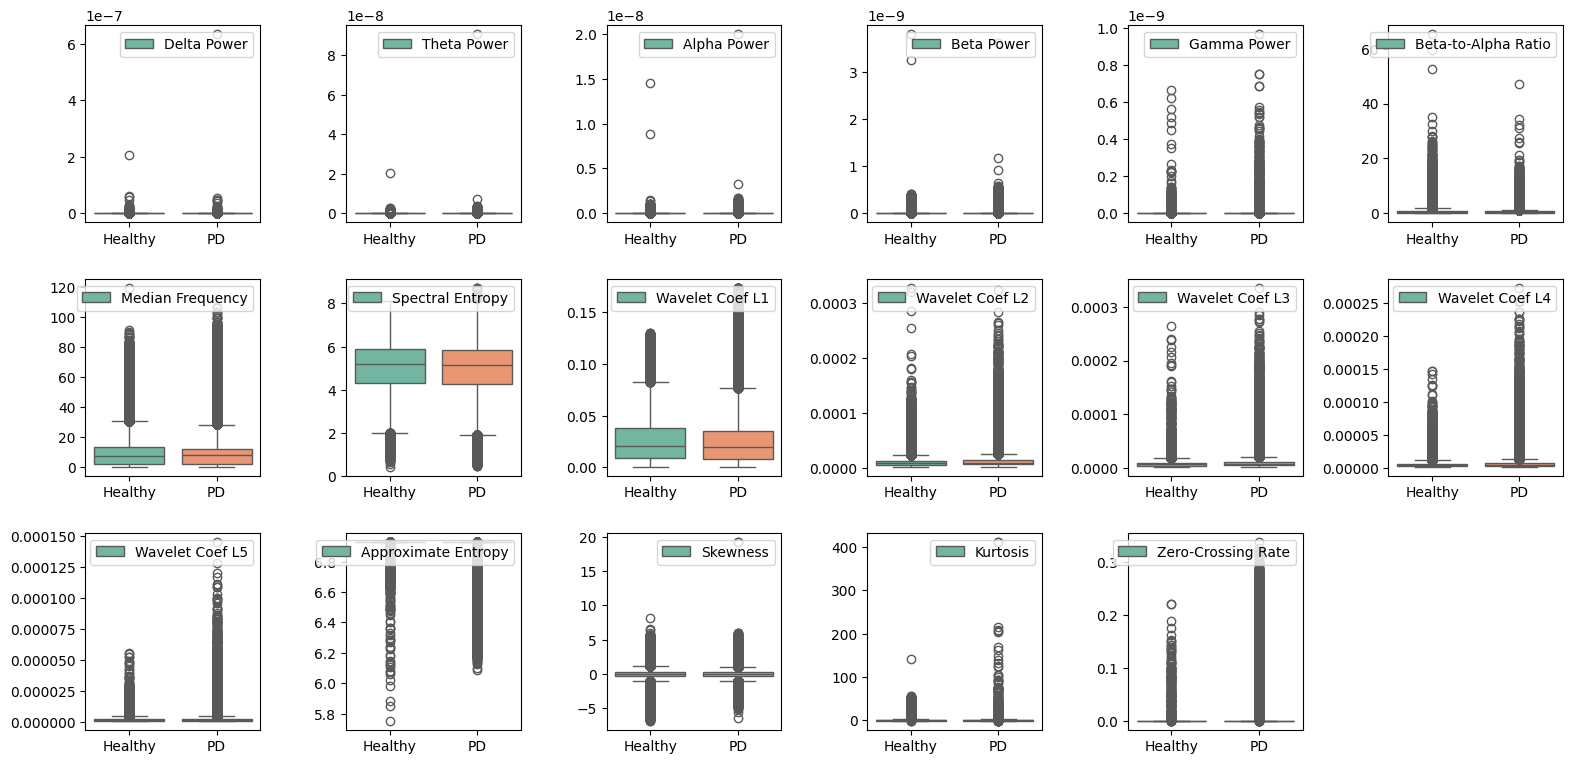

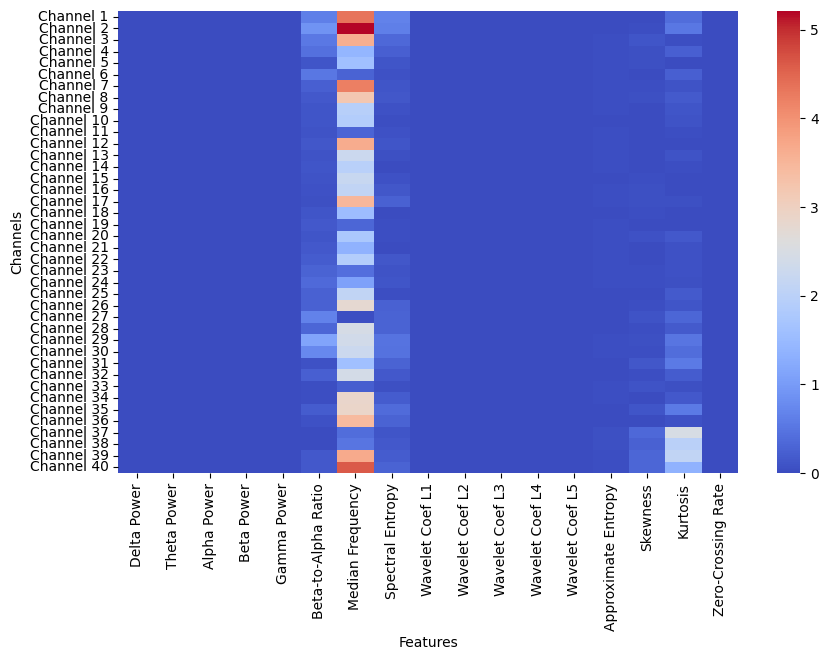

In [44]:
import seaborn as sns

feature_names = [
    "Delta Power", "Theta Power", "Alpha Power", "Beta Power", "Gamma Power",
    "Beta-to-Alpha Ratio", "Median Frequency", "Spectral Entropy",
    "Wavelet Coef L1", "Wavelet Coef L2", "Wavelet Coef L3", "Wavelet Coef L4", "Wavelet Coef L5",
    "Approximate Entropy", "Skewness", "Kurtosis", "Zero-Crossing Rate"
]

healthy_features = reshaped_features[expanded_labels == 'Healthy']
pd_features = reshaped_features[expanded_labels == 'PD']

healthy_mean = np.mean(healthy_features, axis=0)  # Shape: (40, 17)
pd_mean = np.mean(pd_features, axis=0)            # Shape: (40, 17)
feature_diff = np.abs(healthy_mean - pd_mean)     # Absolute difference between classes

plt.figure(figsize=(16, 8))
for i, feature_name in enumerate(feature_names):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(data=[healthy_features[:, :, i].flatten(), pd_features[:, :, i].flatten()], palette="Set2")
    plt.xticks([0, 1], ['Healthy', 'PD'])
    plt.legend([feature_name], loc='upper right')
plt.tight_layout(pad=2.0)

plt.savefig("/content/drive/MyDrive/feature_distributions.eps", format="eps", bbox_inches="tight")
plt.savefig("/content/drive/MyDrive/feature_distributions.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(feature_diff, cmap="coolwarm", cbar=True, yticklabels=[f"Channel {i+1}" for i in range(healthy_mean.shape[0])], xticklabels=feature_names, annot=False)
plt.xlabel("Features")
plt.ylabel("Channels")

plt.savefig("/content/drive/MyDrive/class_difference_heatmap.eps", format="eps", bbox_inches="tight")
plt.savefig("/content/drive/MyDrive/class_difference_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [17]:
from imgaug import augmenters as iaa

def DataAugmentation(Data, Labels, n_augmentations=50):
    """
    Performs data augmentation on EEG feature data.

    Parameters:
    - Data: ndarray of shape (samples, n_channels, n_features)
    - Labels: ndarray of shape (samples,)
    - n_augmentations: Number of augmented samples per original sample

    Returns:
    - augmented_features: ndarray of augmented features
    - augmented_labels: ndarray of corresponding labels
    """

    # Define the augmentation pipeline for EEG feature data
    augmentation = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=(0, 0.05)),    # Add Gaussian noise
        iaa.LinearContrast((0.9, 1.1)),                # Slight contrast adjustment
        iaa.Multiply((0.9, 1.1)),                      # Random scaling of values
    ])

    # Create lists to store augmented data and labels
    augmented_features = []
    augmented_labels = []

    # Augment the data
    for i in range(len(Data)):
        feature = Data[i]
        label = Labels[i]

        # Apply augmentation to the feature and add to the lists
        augmented_features.append(feature)  # Original sample
        augmented_labels.append(label)

        # Generate additional augmented samples for each original sample
        for _ in range(n_augmentations):
            # Apply the augmentation pipeline
            augmented_feature = augmentation.augment_image(feature)

            # Append the augmented feature and label
            augmented_features.append(augmented_feature)
            augmented_labels.append(label)

    # Convert lists to NumPy arrays
    augmented_features = np.array(augmented_features)
    augmented_labels = np.array(augmented_labels)

    # Check the shape of the augmented data
    print("Augmented features shape:", augmented_features.shape)
    print("Augmented labels shape:", augmented_labels.shape)

    return augmented_features, augmented_labels

# Example usage
reshaped_features = reshaped_features.astype(np.float32)
augmented_features, augmented_labels = DataAugmentation(reshaped_features, expanded_labels)

Augmented features shape: (422280, 40, 17)
Augmented labels shape: (422280,)


In [18]:
from sklearn.preprocessing import StandardScaler

def normalize_features(EEG_augmented_features):
    scaler = StandardScaler()
    features_reshaped = EEG_augmented_features.reshape(EEG_augmented_features.shape[0], -1)
    features_scaled = scaler.fit_transform(features_reshaped)
    features_scaled = features_scaled.reshape(EEG_augmented_features.shape)

    return features_scaled

normalized_features = normalize_features(augmented_features)
print("Normalized features shape:", normalized_features.shape)  # Should match EEG_augmented_features.shape

Normalized features shape: (422280, 40, 17)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_labels = encoder.fit_transform(augmented_labels.reshape(-1, 1))

normalized_features = np.array(normalized_features)
X_train, X_test, y_train, y_test = train_test_split(
    normalized_features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

In [20]:
np.shape(X_train)

(337824, 40, 17)

In [21]:
from tensorflow.keras import layers, models

input_shape = X_train.shape[1:]

def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Permute((2, 1))(x)  # Transformer expects (batch, time_steps, features)

    # Transformer Block
    transformer_layer = layers.MultiHeadAttention(num_heads=4, key_dim=20)(x, x)
    transformer_layer = layers.LayerNormalization(epsilon=1e-6)(transformer_layer + x)
    ff_layer = layers.Dense(20, activation="relu")(transformer_layer)
    x = layers.LayerNormalization(epsilon=1e-6)(ff_layer + transformer_layer)

    # LSTM Layer for Sequential Memory
    x = layers.LSTM(64, return_sequences=False)(x)

    # Fully Connected Layers
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, x)
    return model

num_classes = encoded_labels.shape[1]
model = create_model(input_shape, num_classes)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40, 17)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 40, 64)         │          3,328 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 40, 128)        │         24,704 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 20, 128)        │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 20, 128)        │            512 │ max_pooling1d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 128, 20)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 20)        │          6,660 │ permute[0][0],         │
│ (MultiHeadAttention)      │                        │                │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 20)        │              0 │ multi_head_attention[… │
│                           │                        │                │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 20)        │             40 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 20)        │            420 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 20)        │              0 │ dense[0][0],           │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 20)        │             40 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         21,760 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │          8,320 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            258 │ dropout_1[0][0]        │
└──────────────────────

 Total params: 66,042 (257.98 KB)

 Trainable params: 65,786 (256.98 KB)

 Non-trainable params: 256 (1.00 KB)

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 122s 12ms/step - accuracy: 0.9432 - loss: 0.1329 - val_accuracy: 0.9951 - val_loss: 0.0156
Epoch 2/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 113s 12ms/step - accuracy: 0.9955 - loss: 0.0136 - val_accuracy: 0.9967 - val_loss: 0.0108
Epoch 3/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 114s 12ms/step - accuracy: 0.9974 - loss: 0.0080 - val_accuracy: 0.9985 - val_loss: 0.0046
Epoch 4/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 114s 12ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9979 - val_loss: 0.0062
Epoch 5/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 114s 12ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 0.9987 - val_loss: 0.0042
Epoch 6/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 114s 12ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9990 - val_loss: 0.0031
Epoch 7/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 114s 12ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 8/50
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 114s 12ms/step - accuracy: 

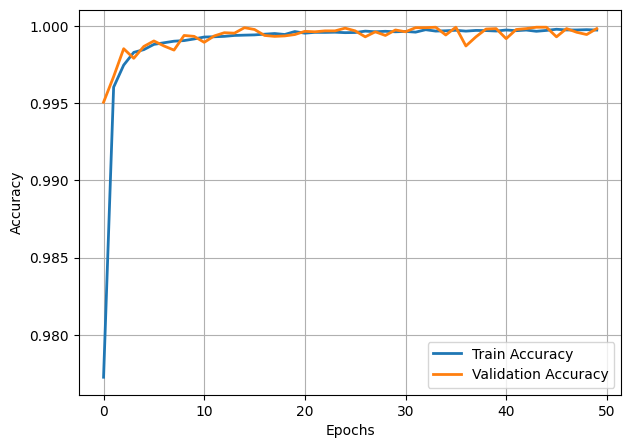

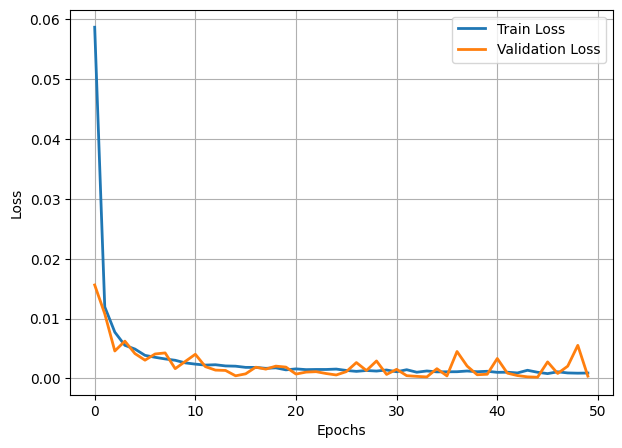

In [40]:
def plot_training_history(history):
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc="best")
    ax1.grid(True)
    fig1.savefig("/content/drive/MyDrive/train_val_accuracy.eps", format="eps")
    fig1.savefig("/content/drive/MyDrive/train_val_accuracy.pdf", format="pdf")
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(7, 5))
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc="best")
    ax2.grid(True)
    fig2.savefig("/content/drive/MyDrive/train_val_loss.eps", format="eps")
    fig2.savefig("/content/drive/MyDrive/train_val_loss.pdf", format="pdf")
    plt.show()

plot_training_history(history)

2640/2640 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


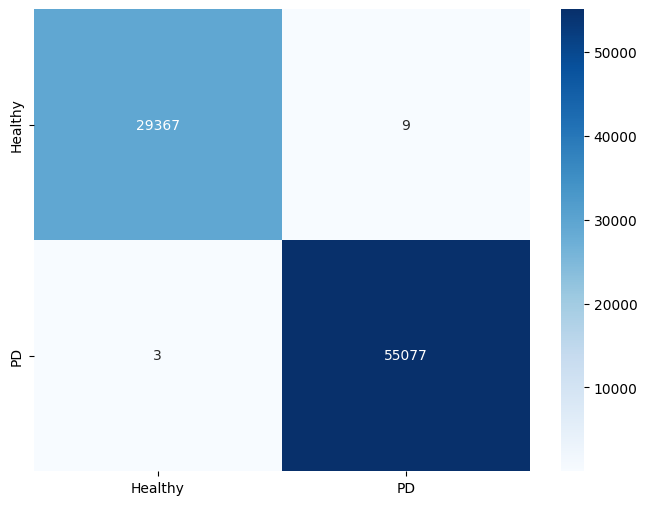

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "PD"], yticklabels=["Healthy", "PD"])
plt.savefig("/content/drive/MyDrive/confusion_matrix.eps", format="eps", bbox_inches='tight')
plt.savefig("/content/drive/MyDrive/confusion_matrix.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [25]:
from sklearn.metrics import classification_report

class_report = classification_report(y_true, y_pred_classes, target_names=["Healthy", "PD"])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00     29376
          PD       1.00      1.00      1.00     55080

    accuracy                           1.00     84456
   macro avg       1.00      1.00      1.00     84456
weighted avg       1.00      1.00      1.00     84456



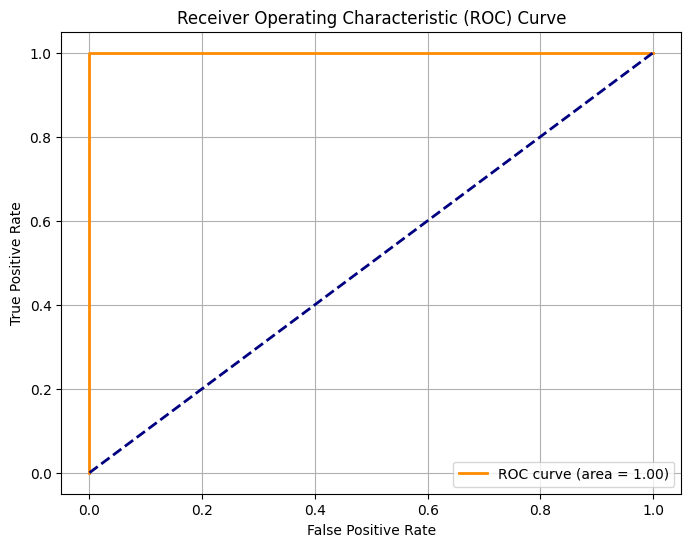

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=[0, 1])
y_pred_binarized = y_pred

fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [27]:
healthy_confidence = y_pred[y_true == 0][:, 0]
pd_confidence = y_pred[y_true == 1][:, 1]
healthy_mean, healthy_std = np.mean(healthy_confidence), np.std(healthy_confidence)
pd_mean, pd_std = np.mean(pd_confidence), np.std(pd_confidence)

print(f"Healthy Confidence - Mean: {healthy_mean:.2f}, Std Dev: {healthy_std:.2f}")
print(f"PD Confidence - Mean: {pd_mean:.2f}, Std Dev: {pd_std:.2f}")

Healthy Confidence - Mean: 1.00, Std Dev: 0.02
PD Confidence - Mean: 1.00, Std Dev: 0.01


In [28]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa_score = cohen_kappa_score(y_true, y_pred_classes)
print(f"Cohen's Kappa Score: {kappa_score:.2f}")

Cohen's Kappa Score: 1.00
